<a href="https://colab.research.google.com/github/KAVYANSHTYAGI/Food-Image-Classifier/blob/main/periodic_adder_denoiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 34.2 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
from multiprocessing import Pool, cpu_count
from tqdm import tqdm  # For progress bar
from sklearn.model_selection import train_test_split  # For splitting

def apply_poisson_noise(image, intensity_factor=50):
    """
    Apply Poisson noise to an image with adjustable intensity.
    Args:
        image: Input image as a NumPy array.
        intensity_factor: Factor to adjust the noise intensity.
    Returns:
        Noisy image as a NumPy array.
    """
    image = image.astype(np.float32)  # Ensure the image is in float32 format
    noisy_image = np.random.poisson(image * intensity_factor) / intensity_factor
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)  # Clip to valid range
    return noisy_image

def process_image(args):
    """
    Process a single image by adding Poisson noise and saving it.
    Args:
        args: A tuple containing image_path, output_path, and intensity_factor.
    """
    image_path, output_path, intensity_factor = args
    try:
        image = cv2.imread(image_path)
        if image is not None:
            noisy_image = apply_poisson_noise(image, intensity_factor)
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            cv2.imwrite(output_path, noisy_image)
            return f"Saved: {output_path}"
        else:
            return f"Failed to read image: {image_path}"
    except Exception as e:
        return f"Error processing {image_path}: {e}"

def process_dataset_with_split(input_folder, output_folder, intensity_factor=50, test_size=0.2):
    """
    Process the dataset by adding Poisson noise, splitting into training and testing sets,
    and saving them in separate folders.
    Args:
        input_folder: Path to the original dataset folder.
        output_folder: Path to save the processed dataset.
        intensity_factor: Factor to adjust the noise intensity.
        test_size: Proportion of the dataset to include in the test split (e.g., 0.2 for 20%).
    """
    train_tasks = []
    test_tasks = []

    for class_name in os.listdir(input_folder):
        class_path = os.path.join(input_folder, class_name)
        if os.path.isdir(class_path):
            image_paths = [
                os.path.join(class_path, image_name)
                for image_name in os.listdir(class_path)
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg'))
            ]

            # Split into training and testing sets
            train_images, test_images = train_test_split(image_paths, test_size=test_size, random_state=42)

            # Add tasks for training images
            for train_image_path in train_images:
                train_output_path = os.path.join(output_folder, "training", class_name, os.path.basename(train_image_path))
                train_tasks.append((train_image_path, train_output_path, intensity_factor))

            # Add tasks for testing images
            for test_image_path in test_images:
                test_output_path = os.path.join(output_folder, "testing", class_name, os.path.basename(test_image_path))
                test_tasks.append((test_image_path, test_output_path, intensity_factor))

    print(f"Total training images to process: {len(train_tasks)}")
    print(f"Total testing images to process: {len(test_tasks)}")

    # Process training images
    with Pool(processes=cpu_count()) as pool:
        print("Processing training images...")
        for result in tqdm(pool.imap_unordered(process_image, train_tasks), total=len(train_tasks)):
            print(result)

    # Process testing images
    with Pool(processes=cpu_count()) as pool:
        print("Processing testing images...")
        for result in tqdm(pool.imap_unordered(process_image, test_tasks), total=len(test_tasks)):
            print(result)

if __name__ == "__main__":
    base_dir = "/content/drive/MyDrive/Food Image Datasets/North Indian/North Indian 30 classes unfiltered"  # Path to original dataset
    output_dir = "/content/drive/MyDrive/Food Image Datasets/North Indian/poisson_final_split"  # Path to save noisy dataset

    # Adjust the intensity factor to increase or decrease noise
    intensity_factor = 50  # Increase for more noticeable noise

    # Process the dataset with an 80-20 train-test split
    process_dataset_with_split(base_dir, output_dir, intensity_factor, test_size=0.2)


In [2]:
image_path = "/content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/veg sandwich - Google Search/1.jpeg"

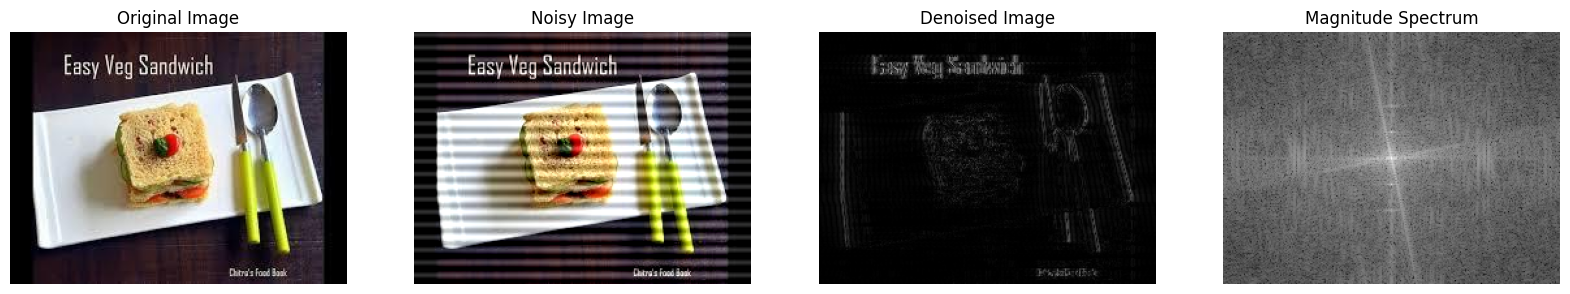

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

def add_periodic_noise(image, frequency=20, amplitude=50):
    rows, cols, _ = image.shape
    noise = np.zeros((rows, cols), dtype=np.float32)
    for i in range(rows):
        noise[i, :] = amplitude * np.sin(2 * np.pi * frequency * i / rows)
    noisy_image = image.astype(np.float32) + noise[:, :, None]
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

def detect_noise_peaks(magnitude_spectrum, threshold=0.5):
    rows, cols = magnitude_spectrum.shape
    horizontal_sum = magnitude_spectrum.sum(axis=1)
    peaks, _ = find_peaks(horizontal_sum, height=threshold * horizontal_sum.max())
    noisy_freqs = [(peak, cols // 2) for peak in peaks]
    return noisy_freqs

def adaptive_notch_filter(image, radius=20, threshold=0.5):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Step 1: FFT
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

    # Step 2: Detect noise frequencies
    noisy_freqs = detect_noise_peaks(magnitude_spectrum, threshold)

    # Step 3: Create a notch mask
    rows, cols = gray.shape
    mask = np.ones((rows, cols), dtype=np.float32)
    for i, j in noisy_freqs:
        cv2.circle(mask, (j, i), radius, 0, -1)

    # Step 4: Apply the mask
    fshift_filtered = fshift * mask

    # Step 5: Inverse FFT
    f_ishift = np.fft.ifftshift(fshift_filtered)
    restored_gray = np.abs(np.fft.ifft2(f_ishift))
    restored_gray = np.clip(restored_gray, 0, 255).astype(np.uint8)

    # Convert back to RGB
    restored_image = cv2.cvtColor(restored_gray, cv2.COLOR_GRAY2RGB)
    return restored_image, magnitude_spectrum

# Input Image Path
  # Replace with your actual image path
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Add Noise
noisy_image = add_periodic_noise(original_image, frequency=20, amplitude=50)

# Apply Adaptive Notch Filter
denoised_image, spectrum = adaptive_notch_filter(noisy_image, radius=30, threshold=0.4)

# Display Results
plt.figure(figsize=(20, 8))
plt.subplot(141), plt.imshow(original_image), plt.title("Original Image")
plt.axis("off")
plt.subplot(142), plt.imshow(noisy_image), plt.title("Noisy Image")
plt.axis("off")
plt.subplot(143), plt.imshow(denoised_image), plt.title("Denoised Image")
plt.axis("off")
plt.subplot(144), plt.imshow(spectrum, cmap="gray"), plt.title("Magnitude Spectrum")
plt.axis("off")
plt.show()


Enter type of noise:- 
1.Vertical Noise
2.Horizontal Noise
3.Right Diagonal Noise
4.Left Diagonal Noise

Enter the Value:- 2


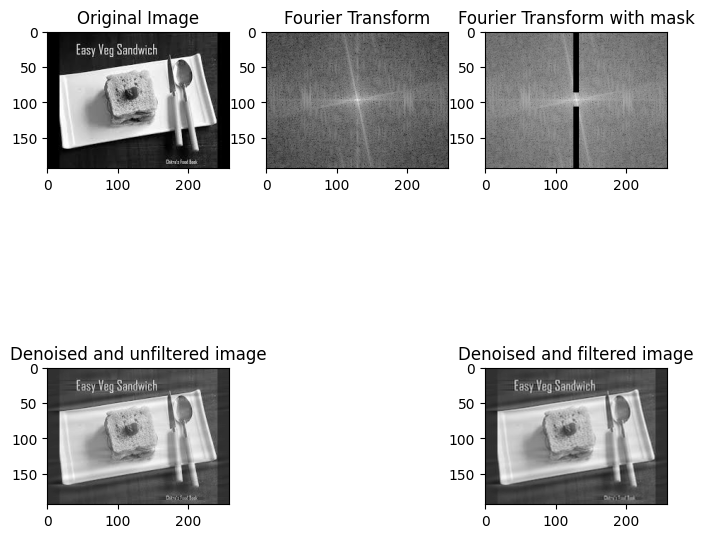

In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt


def distance(point1, point2):
    return sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


def butterworthLP(D0, imgShape, n):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows / 2, cols / 2)
    for x in range(cols):
        for y in range(rows):
            base[y, x] = 1 / (1 + (distance((y, x), center) / D0) ** (2 * n))
    return base


img = cv.imread(image_path, 0)

fourier_transform = np.fft.fft2(img)
center_shift = np.fft.fftshift(fourier_transform)

fourier_noisy = 20 * np.log(np.abs(center_shift))

rows, cols = img.shape
crow, ccol = rows // 2, cols // 2

print("Enter type of noise:- \n1.Vertical Noise\n2.Horizontal Noise\n3.Right Diagonal Noise\n4.Left Diagonal Noise\n")
val = int(input("Enter the Value:- "))

if val == 1:
    # horizontal mask
    center_shift[crow - 4:crow + 4, 0:ccol - 10] = 1
    center_shift[crow - 4:crow + 4, ccol + 10:] = 1
elif val == 2:
    # vertical mask
    center_shift[:crow - 10, ccol - 4:ccol + 4] = 1
    center_shift[crow + 10:, ccol - 4:ccol + 4] = 1
elif val == 3:
    # diagonal-1 mask
    for x in range(0, rows):
        for y in range(0, cols):
            if (x == y):
                for i in range(0, 10):
                    center_shift[x - i, y] = 1
elif val == 4:
    # diagonal-2 mask
    for x in range(0, rows):
        for y in range(0, cols):
            if (x + y == cols):
                for i in range(0, 10):
                    center_shift[x - i, y] = 1

else:
    print("Invalid Input")

filtered = center_shift * butterworthLP(80, img.shape, 10)

f_shift = np.fft.ifftshift(center_shift)
denoised_image = np.fft.ifft2(f_shift)
denoised_image = np.real(denoised_image)

f_ishift_blpf = np.fft.ifftshift(filtered)
denoised_image_blpf = np.fft.ifft2(f_ishift_blpf)
denoised_image_blpf = np.real(denoised_image_blpf)

fourier_noisy_noise_removed = 20 * np.log(np.abs(center_shift))

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(2, 3, 1)
ax1.title.set_text("Original Image")
ax1.imshow(img, cmap='gray')
ax2 = fig.add_subplot(2, 3, 2)
ax2.imshow(fourier_noisy, cmap='gray')
ax2.title.set_text("Fourier Transform")
ax3 = fig.add_subplot(2, 3, 3)
ax3.imshow(fourier_noisy_noise_removed, cmap='gray')
ax3.title.set_text("Fourier Transform with mask")
ax4 = fig.add_subplot(2, 3, 4)
ax4.imshow(denoised_image, cmap='gray')
ax4.title.set_text("Denoised and unfiltered image")
ax5 = fig.add_subplot(2, 3, 6)
ax5.imshow(denoised_image_blpf, cmap='gray')
ax5.title.set_text("Denoised and filtered image")

plt.show()

Enter type of noise:- 
1.Vertical Noise
2.Horizontal Noise
3.Right Diagonal Noise
4.Left Diagonal Noise

Enter the Value:- 2


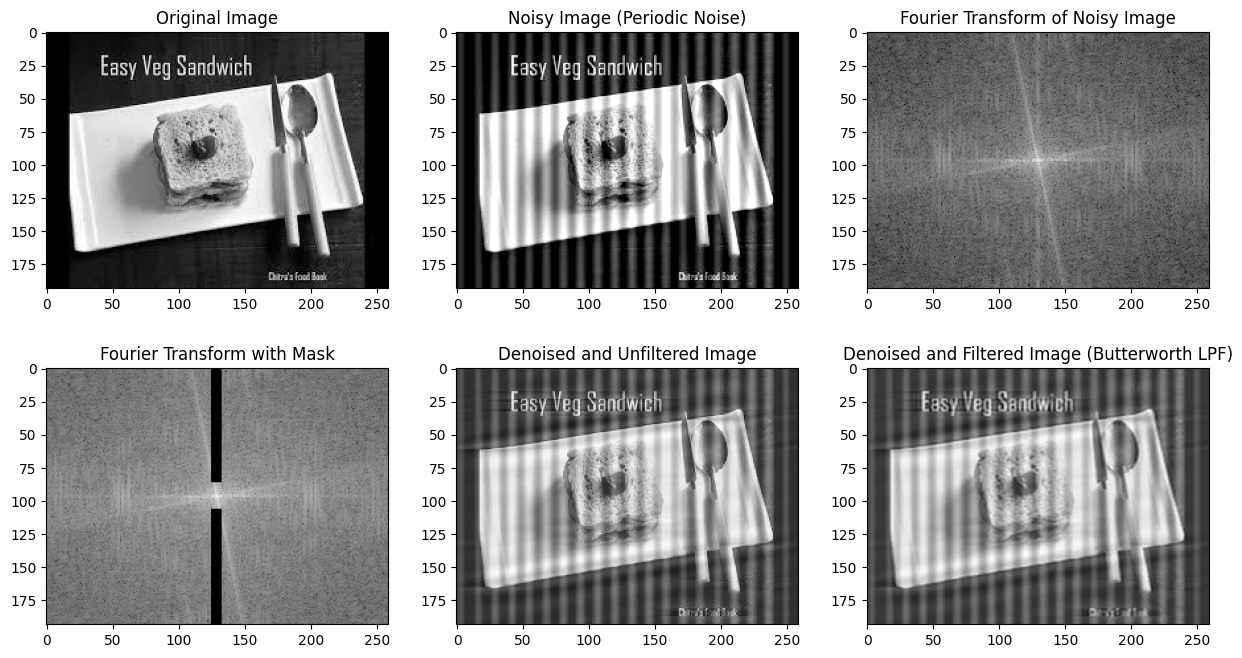

In [7]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt


def distance(point1, point2):
    return sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


def butterworthLP(D0, imgShape, n):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows / 2, cols / 2)
    for x in range(cols):
        for y in range(rows):
            base[y, x] = 1 / (1 + (distance((y, x), center) / D0) ** (2 * n))
    return base


def add_periodic_noise(image, frequency=20, amplitude=20):
    """
    Adds periodic noise to an image.
    Args:
        image: Input grayscale image (NumPy array).
        frequency: Frequency of the periodic noise.
        amplitude: Amplitude of the periodic noise.
    Returns:
        Noisy image with periodic noise (NumPy array).
    """
    rows, cols = image.shape
    noise = np.zeros((rows, cols), dtype=np.float32)
    for x in range(cols):
        noise[:, x] = amplitude * np.sin(2 * np.pi * frequency * x / cols)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image


# Load Image

original_image = cv.imread(image_path, 0)

# Add periodic noise
noisy_image = add_periodic_noise(original_image, frequency=20, amplitude=50)

# Apply Fourier Transform to the noisy image
fourier_transform = np.fft.fft2(noisy_image)
center_shift = np.fft.fftshift(fourier_transform)
fourier_noisy = 20 * np.log(np.abs(center_shift))

rows, cols = noisy_image.shape
crow, ccol = rows // 2, cols // 2

# Add noise suppression mask based on user input
print("Enter type of noise:- \n1.Vertical Noise\n2.Horizontal Noise\n3.Right Diagonal Noise\n4.Left Diagonal Noise\n")
val = int(input("Enter the Value:- "))

if val == 1:
    # horizontal mask
    center_shift[crow - 4:crow + 4, 0:ccol - 10] = 1
    center_shift[crow - 4:crow + 4, ccol + 10:] = 1
elif val == 2:
    # vertical mask
    center_shift[:crow - 10, ccol - 4:ccol + 4] = 1
    center_shift[crow + 10:, ccol - 4:ccol + 4] = 1
elif val == 3:
    # diagonal-1 mask
    for x in range(0, rows):
        for y in range(0, cols):
            if x == y:
                for i in range(0, 10):
                    center_shift[x - i, y] = 1
elif val == 4:
    # diagonal-2 mask
    for x in range(0, rows):
        for y in range(0, cols):
            if x + y == cols:
                for i in range(0, 10):
                    center_shift[x - i, y] = 1
else:
    print("Invalid Input")

# Apply Butterworth Low Pass Filter
filtered = center_shift * butterworthLP(80, noisy_image.shape, 10)

# Inverse FFT for both masked and filtered images
f_shift = np.fft.ifftshift(center_shift)
denoised_image = np.fft.ifft2(f_shift)
denoised_image = np.real(denoised_image)

f_ishift_blpf = np.fft.ifftshift(filtered)
denoised_image_blpf = np.fft.ifft2(f_ishift_blpf)
denoised_image_blpf = np.real(denoised_image_blpf)

fourier_noisy_noise_removed = 20 * np.log(np.abs(center_shift))

# Display Results
fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(2, 3, 1)
ax1.title.set_text("Original Image")
ax1.imshow(original_image, cmap="gray")

ax2 = fig.add_subplot(2, 3, 2)
ax2.imshow(noisy_image, cmap="gray")
ax2.title.set_text("Noisy Image (Periodic Noise)")

ax3 = fig.add_subplot(2, 3, 3)
ax3.imshow(fourier_noisy, cmap="gray")
ax3.title.set_text("Fourier Transform of Noisy Image")

ax4 = fig.add_subplot(2, 3, 4)
ax4.imshow(fourier_noisy_noise_removed, cmap="gray")
ax4.title.set_text("Fourier Transform with Mask")

ax5 = fig.add_subplot(2, 3, 5)
ax5.imshow(denoised_image, cmap="gray")
ax5.title.set_text("Denoised and Unfiltered Image")

ax6 = fig.add_subplot(2, 3, 6)
ax6.imshow(denoised_image_blpf, cmap="gray")
ax6.title.set_text("Denoised and Filtered Image (Butterworth LPF)")

plt.show()


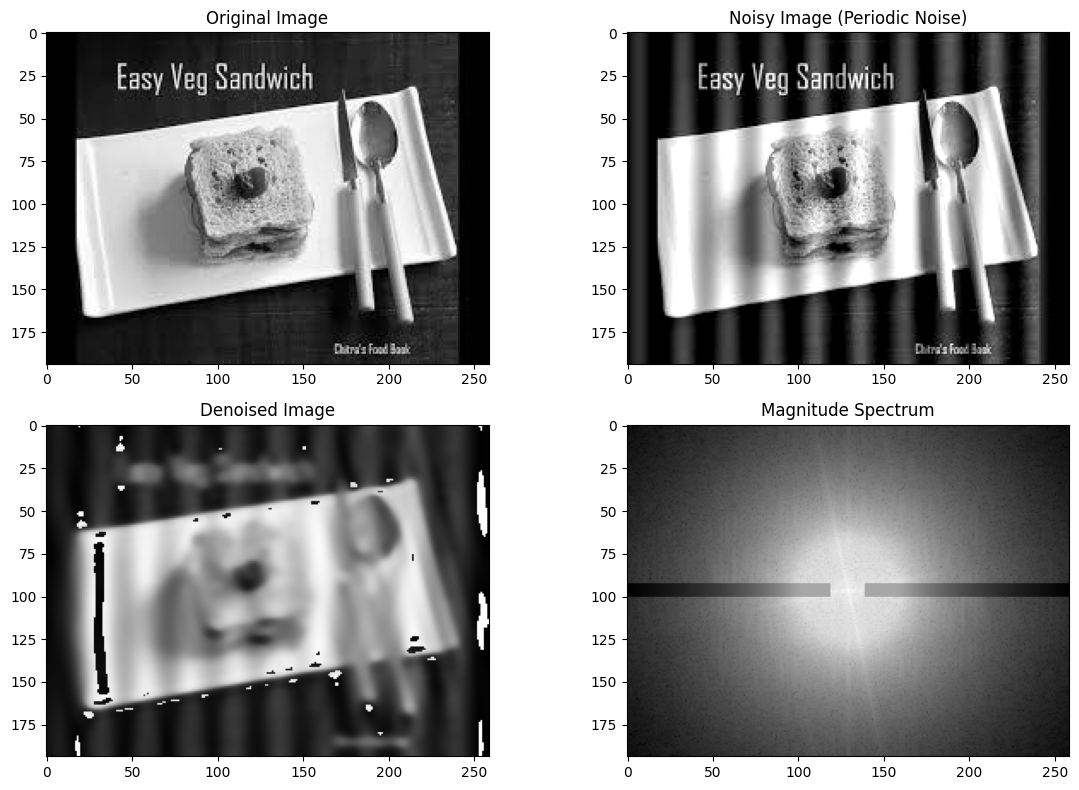

In [6]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt


def distance(point1, point2):
    return sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


def butterworthLP(D0, imgShape, n):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows / 2, cols / 2)
    for x in range(cols):
        for y in range(rows):
            base[y, x] = 1 / (1 + (distance((y, x), center) / D0) ** (2 * n))
    return base


def add_periodic_noise(image, freq=10, amp=50):
    rows, cols = image.shape[:2]
    x = np.arange(cols)
    y = np.sin(2 * np.pi * freq * x / cols) * amp
    noisy_image = image.copy().astype(np.float32)
    for i in range(rows):
        noisy_image[i, :] += y
    return np.clip(noisy_image, 0, 255).astype(np.uint8)


def denoise_image_with_butterworth(noisy_image, D0=30, n=10):
    # Fourier Transform
    fourier_transform = np.fft.fft2(noisy_image)
    center_shift = np.fft.fftshift(fourier_transform)

    # Create Mask
    rows, cols = noisy_image.shape
    crow, ccol = rows // 2, cols // 2
    center_shift[crow - 4:crow + 4, 0:ccol - 10] = 1  # Example for horizontal noise
    center_shift[crow - 4:crow + 4, ccol + 10:] = 1

    # Apply Butterworth Filter
    filtered = center_shift * butterworthLP(D0, noisy_image.shape, n)

    # Inverse FFT
    f_ishift_blpf = np.fft.ifftshift(filtered)
    denoised_image_blpf = np.fft.ifft2(f_ishift_blpf)
    denoised_image_blpf = np.real(denoised_image_blpf)

    # Post-process with Bilateral Filter
    denoised_image_final = cv.bilateralFilter(denoised_image_blpf.astype(np.uint8), 9, 75, 75)

    return denoised_image_final, filtered


original_image = cv.imread(image_path, 0)

# Add Periodic Noise
noisy_image = add_periodic_noise(original_image, freq=10, amp=50)

# Denoise Image
denoised_image, _ = denoise_image_with_butterworth(noisy_image, D0=30, n=10)

# Display Results
plt.figure(figsize=(12, 8))
plt.subplot(221), plt.imshow(original_image, cmap='gray'), plt.title("Original Image")
plt.subplot(222), plt.imshow(noisy_image, cmap='gray'), plt.title("Noisy Image (Periodic Noise)")
plt.subplot(223), plt.imshow(denoised_image, cmap='gray'), plt.title("Denoised Image")
plt.subplot(224), plt.imshow(20 * np.log(np.abs(_)), cmap='gray'), plt.title("Magnitude Spectrum")
plt.tight_layout()
plt.show()
